### Instructions

In this lab, you will be using the [Sakila](https://dev.mysql.com/doc/sakila/en/) database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
2. Read the data into a Pandas dataframe.
3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.

In [1]:
import pymysql # Not for every version necessary
from sqlalchemy import create_engine # To create connection with SQL Workbench
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler # To normalise the numerical data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns # Build on matplot to create more compley plots

%matplotlib inline
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


#### 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

#### 2. Read the data into a Pandas dataframe.

In [7]:
query = """SELECT f.film_id, f.title, f.rental_duration, f.rental_rate, f.rating, fc.category_id, r.rental_id, r.rental_date, r.return_date
FROM film f
JOIN film_category fc 
ON f.film_id = fc.film_id
JOIN inventory i 
ON f.film_id = i.film_id
JOIN rental r 
ON i.inventory_id = r.inventory_id;"""

data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,rental_duration,rental_rate,rating,category_id,rental_id,rental_date,return_date
0,19,AMADEUS HOLY,6,0.99,PG,1,10895,2005-08-02 01:16:59,2005-08-03 02:41:59
1,19,AMADEUS HOLY,6,0.99,PG,1,12268,2005-08-18 04:26:54,2005-08-23 06:40:54
2,19,AMADEUS HOLY,6,0.99,PG,1,3150,2005-06-20 20:35:28,2005-06-26 01:01:28
3,19,AMADEUS HOLY,6,0.99,PG,1,5072,2005-07-09 05:01:58,2005-07-18 08:17:58
4,19,AMADEUS HOLY,6,0.99,PG,1,9080,2005-07-30 08:02:39,2005-08-06 12:02:39


#### 3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [8]:
data.rental_rate.unique()

array([0.99, 4.99, 2.99])

In [9]:
data.rental_duration.unique()

array([6, 3, 5, 7, 4])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   film_id          16044 non-null  int64         
 1   title            16044 non-null  object        
 2   rental_duration  16044 non-null  int64         
 3   rental_rate      16044 non-null  float64       
 4   rating           16044 non-null  object        
 5   category_id      16044 non-null  int64         
 6   rental_id        16044 non-null  int64         
 7   rental_date      16044 non-null  datetime64[ns]
 8   return_date      15861 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 1.1+ MB


In [11]:
data.isna().sum()

film_id              0
title                0
rental_duration      0
rental_rate          0
rating               0
category_id          0
rental_id            0
rental_date          0
return_date        183
dtype: int64

##### I preprocess the 'rental_date' column to extract the month and year information.

In [13]:
data['rental_month'] = data['rental_date'].dt.month
data['rental_year'] = data['rental_date'].dt.year

##### I want to keep the rows with nulls in return_date, since the respective copy of a film cannot be rented if it has not been returned. Instead of deleting I extract the month and year information from the 'return_date' column, and calculate the rental duration based on the rental date and duration to fill the nulls in return date. 

In [14]:
# First, I calculate the expected return date based on the rental date and duration
data['expected_return_date'] = data['rental_date'] + pd.to_timedelta(data['rental_duration'], unit='D')

# I fill in null values in the `return_date` column with the expected return date
data['return_date'] = np.where(data['return_date'].isnull(), data['expected_return_date'], data['return_date'])

# The I extract the month and year information from the `return_date` column
data['return_month'] = data['return_date'].dt.month
data['return_year'] = data['return_date'].dt.year

In [24]:
data.isna().sum()

film_id                 0
title                   0
rental_duration         0
rental_rate             0
rental_id               0
rental_date             0
return_date             0
rental_month            0
rental_year             0
expected_return_date    0
return_month            0
return_year             0
num_rentals_total       0
category_1              0
category_2              0
category_3              0
category_4              0
category_5              0
category_6              0
category_7              0
category_8              0
category_9              0
category_10             0
category_11             0
category_12             0
category_13             0
category_14             0
category_15             0
category_16             0
rating_G                0
rating_NC-17            0
rating_PG               0
rating_PG-13            0
rating_R                0
dtype: int64

##### I add a new column 'num_rentals_total' which features the sum of rentals for each film to measure popularity of films.

In [16]:
# I group the data by film_id and count the number of rentals.
num_rentals = data.groupby('film_id')['rental_id'].transform('count')

# I add the num_rentals column.
data['num_rentals_total'] = num_rentals

/Users/ingaeumann/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


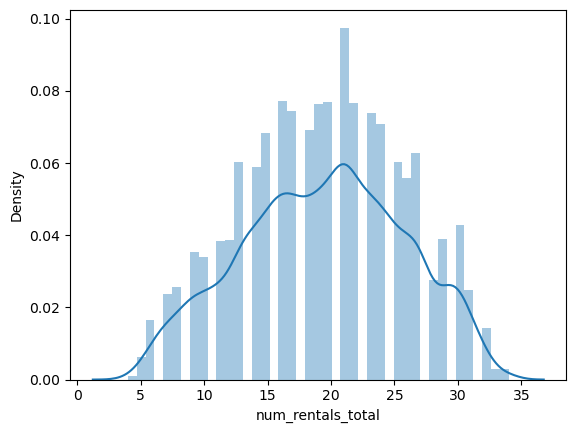

In [17]:
sns.distplot(data['num_rentals_total'])

plt.show()

/Users/ingaeumann/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


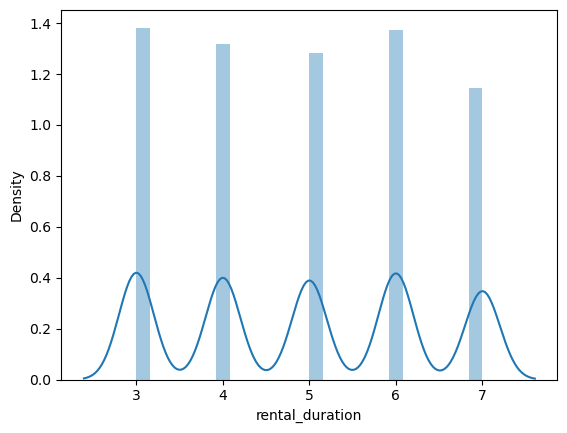

In [18]:
sns.distplot(data['rental_duration'])

plt.show()

##### I encode the 'category_id'  and the 'rating' column for proper usage.

In [20]:
category_id_encoded = pd.get_dummies(data['category_id'], prefix='category')

# I add the one-hot encoded columns to the dataframe
data = pd.concat([data, category_id_encoded], axis=1)

# And I drop the original category_id column
data = data.drop(['category_id'], axis=1)

In [22]:
rating_encoded = pd.get_dummies(data['rating'], prefix='rating')

data = pd.concat([data, rating_encoded], axis=1)

data = data.drop('rating', axis=1)

In [23]:
data.columns.unique()

Index(['film_id', 'title', 'rental_duration', 'rental_rate', 'rental_id',
       'rental_date', 'return_date', 'rental_month', 'rental_year',
       'expected_return_date', 'return_month', 'return_year',
       'num_rentals_total', 'category_1', 'category_2', 'category_3',
       'category_4', 'category_5', 'category_6', 'category_7', 'category_8',
       'category_9', 'category_10', 'category_11', 'category_12',
       'category_13', 'category_14', 'category_15', 'category_16', 'rating_G',
       'rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R'],
      dtype='object')

#### 4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [25]:
from datetime import datetime, timedelta

# First I have to find the last return date.
last_return_date = data['return_date'].max()

# I define the previous month as the month before the last return date.
prev_month = last_return_date.replace(day=1) - timedelta(days=1)

# Then I  use a lambda function to check if a rental occurred in the previous month.
check_prev_month = lambda x: 1 if x >= prev_month else 0

# And I apply the lambda function to the return_date column and store the result in a new column.
data['rented_last_month'] = data['return_date'].apply(check_prev_month)

In [26]:
data.rented_last_month.unique()

array([0, 1])

##### I drop the columns in datetime format since I have converted them into individual columns in int format. Also the column 'rental_id' since I have the 'num_rentals_total' now. And the column 'title' since as an object it'll give issues when fitting the model.

In [27]:
data = data.drop(columns=['rental_date', 'return_date', 'expected_return_date', 'rental_id', 'title'])

In [29]:
data.columns.unique()

Index(['film_id', 'rental_duration', 'rental_rate', 'rental_month',
       'rental_year', 'return_month', 'return_year', 'num_rentals_total',
       'category_1', 'category_2', 'category_3', 'category_4', 'category_5',
       'category_6', 'category_7', 'category_8', 'category_9', 'category_10',
       'category_11', 'category_12', 'category_13', 'category_14',
       'category_15', 'category_16', 'rating_G', 'rating_NC-17', 'rating_PG',
       'rating_PG-13', 'rating_R', 'rented_last_month'],
      dtype='object')

#### 5. Create a logistic regression model to predict this variable from the cleaned data.

In [30]:
y = data['rented_last_month'] 
X = data.drop('rented_last_month', axis=1)

In [31]:
# First I split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [66]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [72]:
predictions = model.predict(X_test)
# Now I want to list the films that have a high probability to be rented in the coming month. 
predicted_rentals = data.iloc[X_test.index][predictions > 0.5][['film_id']]
print(predicted_rentals)

       film_id
9538       281
2021       820
15399      233
13212      151
7874       603
280        229
8587       376
15184      902
8629       399
3098       873
15774      648
9192       792
9436       200
12291      270
10187      861
7969       639
10275      956
2140       886
14184      254
14812      733
637        574
7652       391
12615      677
3316       131
9522       264
4295       178
11059      870
4506       388
872        823
119        105
1934       696
7302        53
1457       300
15568      405
15614      451
676        586
10379       13
11184       17
6253       146
14389      420
1513       326
245        205
11377      220
5379       219
499        375


#### 6. Evaluate the results.

In [69]:
pd.Series(predictions).value_counts()

0    3966
1      45
dtype: int64

In [70]:
y_test.value_counts()

0    3966
1      45
Name: rented_last_month, dtype: int64

In [71]:
model.score(X_test, y_test)

1.0

##### The model seems to predict perfectly. But I think it might be unbalanced since there were rentals only in half the month of February. I also tried with August 2005 which is the previous month with rentals, but during that month every film was rented hence the model was even more unbalanced.